In [715]:
# Convenience
import sys
sys.path.append('..')
import numpy as np
from tqdm.notebook import tqdm
import astropy.units as u

%load_ext autoreload
%autoreload 2

# Math
from scipy.stats import shapiro

# Plotting
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook
from plot_params import params
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
import plottools as pt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from einops import rearrange

# Greg's Model
import lenstools as lt
from lenstools import nrm

# Sid's Model
from units import *
from astrosim import AstrometricSim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sid's Simulation

Lenses
- $\theta_i, \phi_i \sim$ Uniform$(-w/2, w/2)$ arcseconds
- $D_i \sim$ Delta(1 kpc)
- $\vec{v}_{\perp, i} \sim$ Uniform$(-150,150)$ km/s
- $\dot{D}_i \sim$ Delta(0)

Sources
- $\theta_i, \phi_i \sim$ Uniform$(-.1, .1)$ arcseconds
- $\dot{\theta}_i, \dot{\phi}_i \sim$ Normal$(0,2 \times 10^{-5})$ arcsec/yr
- $D_i, \dot{D}_i$ undefined

Observer
- Stationary (no parallax)

Calculations
- $\Delta \vec{\theta} = \frac{4 G_N M}{b} \hat{b}$
- $\vec{b} = (\vec{\theta}_s - \vec{\theta}_l) * D_l$
- $\vec{\mu}_l = \vec{v}_{\perp} / D_l$

$w = $ window width, in arcseconds

In [915]:
w = .1  # snapshot width
mult = .1/w

std_mu_s = 2e-5  # characteristic source angular velocity

error_mu = 5e-15  # measurement error

n_sim = int(1e5)  # Training set size

In [916]:
%autoreload
# Dummy initialization, just to set some global vars

ds = AstrometricSim(theta_x_lims = [-w, w], theta_y_lims = [-w, w])
ds.animation(
    pos_l=np.array([[0.,0]]),
    v_l=np.array([[200, 0]]) * Kmps,
    R_l=[10 * pc], M_l=[0], D_l=[1 * kpc],
    n_dens=500 * mult**2, std_mu_s=1e-6, source_pos="random")


# Simulation

x = np.zeros((n_sim, ds.n_total, 10, 2))
y = np.zeros((n_sim))
y_lens_pos = np.zeros((n_sim, 2))
y_pos = np.zeros((n_sim, 10, 2))

for i_sim in tqdm(range(n_sim)):
    
    ds = AstrometricSim(theta_x_lims = [-w, w], theta_y_lims = [-w, w])
    
    y_lens = np.random.randint(2)
    y[i_sim] = y_lens
    
    if y_lens:
        M_l = 10 ** 7. * M_s
    else:
        M_l = 0
    
    # Uniformly distributed sources from -.1/2 to .1/2
    pos_l = w * (np.random.random(2) - 0.5)
    v_l = 300. * (np.random.random(2) - 0.5)
    
    y_lens_pos[i_sim] = pos_l
    
    anim = ds.animation(
        pos_l=np.array([pos_l]),
        v_l=np.array([v_l]) * Kmps,
        R_l=[1 * pc], M_l=[M_l], D_l=[1 * kpc],
        n_dens=500 * mult**2, std_mu_s=std_mu_s, source_pos="random")

    for i in range(10):
        
        ds.propagate(dt=25)
        
        x[i_sim, : , i, 0] = ds.sources["theta_x"]
        x[i_sim, : , i, 1] = ds.sources["theta_y"]
        
        y_pos[i_sim, i, 0] = ds.lenses["theta_x"]
        y_pos[i_sim, i, 1] = ds.lenses["theta_y"]
        
# Add measurement errors

x_err = np.random.normal(loc=0, scale=error_mu, size=(x.shape))
x += x_err

x = torch.Tensor(x)
y = torch.Tensor(y)

# # Normalize and rotate data

x = x - x[:, :, 0, :].unsqueeze(-2)  # Set first position to zero
theta = torch.atan2(x[:, :, -1, 1], x[:, :, -1, 0]).numpy()  # Get rotation angle
rot = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]])  # Get rotation matrix
rot = torch.Tensor(rearrange(rot, 'i j k l  -> k l i j'))
x = torch.matmul(x, rot)  # Rotate (CHECK)

# Standardize input data by Z-scoring
x = (x - x.mean(0).mean(0)) / x.std(0).std(0)
x[:, :, 0, :] = 0.

/Users/gregoryridgway/Desktop/AstroML/Astrometric_TSeries_ML/notebooks/astrosim.py:59: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.sources = np.zeros(
/Users/gregoryridgway/Desktop/AstroML/Astrometric_TSeries_ML/notebooks/astrosim.py:100: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.lenses = np.zeros(self.n_lens, dtype=[("theta_x", float, 1),


  0%|          | 0/100000 [00:00<?, ?it/s]

Text(0.5, 1.0, "Sid's Data")

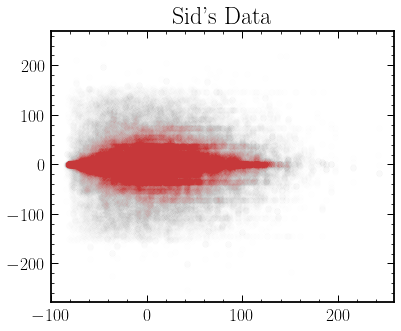

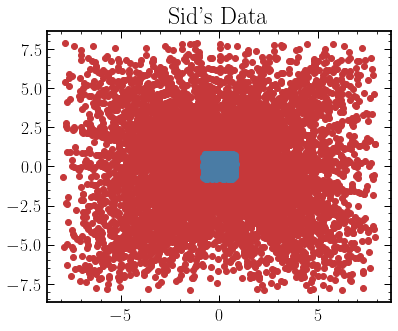

In [683]:
plt.figure()
# plt.axis([-120,250, -250, 250])
# plt.axis([-.12,.12,-.12,.12])
plt.scatter(x[:,:,:,0].flatten(), x[:,:,:,1].flatten(), alpha=2e-3)
plt.title('Sid\'s Data', fontsize=24)

plt.figure()
# plt.axis([-120,250, -250, 250])
# plt.axis([-.12,.12,-.12,.12])
plt.scatter(y_pos[:,:,0].flatten(), y_pos[:,:,1].flatten(), alpha=1e-0)
plt.scatter(y_pos[:,0,0].flatten(), y_pos[:,0,1].flatten(), alpha=1e-0)
plt.title('Sid\'s Data', fontsize=24)

# Greg's Simulation

In [924]:
%autoreload
import lenstools as lt
import pickle

match_Sid = True

inv_cdf_raw = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/'+
                              'Astrometric_TSeries_ML/data/Gaia_DR2_inv_cdf', 'rb'))
def inv_cdf(p):
    return inv_cdf_raw(p) * 1e-3  # converts to kpc

N_t = int(1e5)  # training set size
N_o = 10  # number of observations
N_spl = 20  # sources per lens

# Distribution of lens masses and radii
# M_l = 10**np.random.uniform(6.9, 7, size=N_t)
# R_l = 10**np.random.uniform(-3.5, -2.5, size=N_t)
M_l = 10**7  # 10^7 solar masses
R_l = 1e-3  # one parsec
kind = 'Gaussian'

# 50/50 chance if lens is present or not
lens_present = np.random.choice([0,1], size=N_t)
M_l *= lens_present

dt = 25 #0.02
scale = [1., 1., 1.]

# Create an observer
if match_Sid:
    parallax = False
else:
    parallax = True
    
obs = lt.Observer(parallax, units=False)

lenses, sources = lt.sample('standard', N_t, scale,
                            inv_cdf, obs, kind, M_l, R_l, N_spl=N_spl,
                            match_Sid=match_Sid)

# Go from full sky to theta, phi patch
window = np.array([-w, w])
offset = np.ones(2) * np.pi/2 / lt.arcsec
sources.mod_angles(offset + window, window)  # theta, phi

if match_Sid:
    window /= 2
    
lenses.mod_angles(offset + window, window)

# Make the sources as slow as Sid's simulation
if match_Sid:
#     sources.v = sources.v/1e3

    # slower, Gaussian distributed source velocities
    rand_mu = np.random.normal(loc=0, scale=2e-5 * lt.arcsec, size=(N_t * N_spl, 2))
    D_s = nrm(sources.x)[:,np.newaxis]
    sources.v = np.insert(rand_mu * D_s,
                          0, np.zeros(N_t * N_spl), axis=1)
    
    # faster, uniformly distributed lens velocities
    
    lens_v = 300 * (np.random.random((N_t, 2)) - 0.5) * 1e-9  # [v_y, v_z]
    lens_v = np.insert(lens_v, 0, np.zeros(N_t), axis=1)  # [v_x=0, v_y, v_z]
    lens_v = np.repeat(lens_v, N_spl, axis=0)  # duplicate
    
    lenses.v = lens_v

if match_Sid:
    method = 'match_Sid'
else:
    method = 'fully_approximate'

data = obs.observe(sources, lenses, N=N_o, dt=dt, zeroed=False, method=method)
angles = (data.reshape(N_t, N_spl, N_o, 2) - np.array([np.pi/2, 0]))/lt.arcsec

lens_pos = obs.observe(lenses, N=N_o, dt=dt, zeroed=False)[::N_spl]
lens_pos = (lens_pos - np.array([np.pi/2, 0]))/lt.arcsec

# Add error
error_mu = 5e-15

data_err = np.random.normal(loc=0, scale=error_mu, size=(angles.shape))
angles += data_err

x2 = torch.Tensor(angles)
y2 = torch.Tensor(lens_present)

# Normalize and rotate data
x2 = x2 - x2[:, :, 0, :].unsqueeze(-2)  # Set first position to zero
theta = torch.atan2(x2[:, :, -1, 1], x2[:, :, -1, 0]).numpy()  # Get rotation angle
rot = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]])  # Get rotation matrix
rot = torch.Tensor(rearrange(rot, 'i j k l  -> k l i j'))
x2 = torch.matmul(x2, rot)  # Rotate (CHECK)

# Standardize input data by Z-scoring
x2 = (x2 - x2.mean(0).mean(0)) / x2.std(0).std(0)
x2[:, :, 0, :] = 0.

Lenses
- $\theta_i, \phi_i \sim$ Uniform$(-w/2, w/2)$ arcseconds
- $D_i \sim$ Delta(1 kpc)
- $\vec{v}_{\perp, i} \sim$ Uniform$(-150,150)$ km/s
- $\dot{D}_i \sim$ Delta(0)

Sources
- $\theta_i, \phi_i \sim$ Uniform$(-.1, .1)$ arcseconds
- $\dot{\theta}_i, \dot{\phi}_i \sim$ Normal$(0,2 \times 10^{-5})$ arcsec/yr
- $D_i, \dot{D}_i$ undefined

Observer
- Stationary (no parallax)

Calculations
- $\Delta \vec{\theta} = \frac{4 G_N M}{b} \hat{b}$
- $\vec{b} = (\vec{\theta}_s - \vec{\theta}_l) * D_l$
- $\vec{\mu}_l = \vec{v}_{\perp} / D_l$

$w = $ window width, in arcseconds

% of lenses 1kpc away: 1.0
% of lenses with \dot{D} = 0: 1.0
Normality of mu_s
\vec{mean} [3.20352279e-08 2.68323992e-07]
\vec{std} [1.98394040e-05 1.99510993e-05]
Shapiro-Wilk test:


(ShapiroResult(statistic=0.9998600482940674, pvalue=0.27050772309303284),
 ShapiroResult(statistic=0.9999327063560486, pvalue=0.9165975451469421))

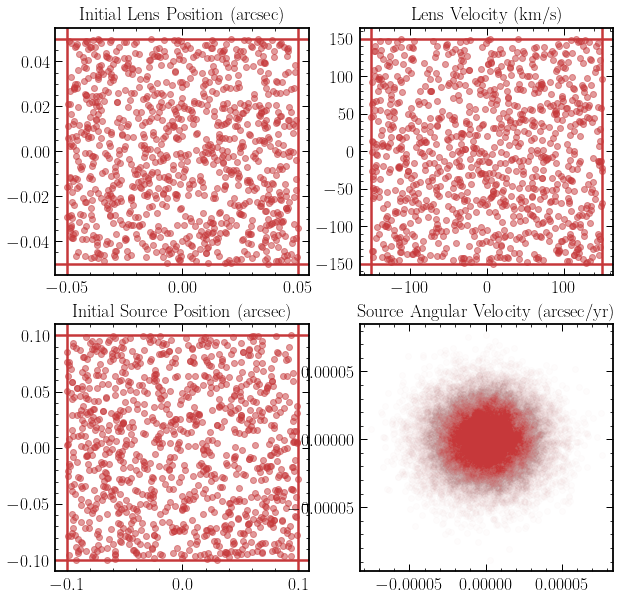

In [851]:
# Test assumptions

f, axarr = plt.subplots(2,2, figsize = (10,10))

print('% of lenses 1kpc away:', 
      sum(np.abs(1-nrm(lenses.x)) < 1e-14)/lenses.N)

print('% of lenses with \dot{D} = 0:', 
      sum(lenses.v[:,0] == 0)/lenses.N)

# Lenses
axarr[0][0].scatter(lens_pos[:,0,0], lens_pos[:,0,1], alpha = 0.5)
[axarr[0][0].axvline(-ww) for ww in window]
[axarr[0][0].axhline(-ww) for ww in window]
axarr[0][0].set_title('Initial Lens Position (arcsec)')

axarr[0][1].scatter(lenses.v[:,1][::N_spl]*1e9, lenses.v[:,2][::N_spl]*1e9, alpha=0.5)
[axarr[0][1].axvline(-ww) for ww in [-150,150]]
[axarr[0][1].axhline(-ww) for ww in [-150,150]]
axarr[0][1].set_title('Lens Velocity (km/s)')


# Sources
axarr[1][0].scatter(angles[:,0,0,0].flatten(),
                    angles[:,0,0,1].flatten(), alpha = 0.5)
[axarr[1][0].axvline(-ww) for ww in window*2]
[axarr[1][0].axhline(-ww) for ww in window*2]
axarr[1][0].set_title('Initial Source Position (arcsec)')


mu_s = (sources.v[:,1:] / nrm(sources.x)[:,np.newaxis]) / lt.arcsec
axarr[1][1].scatter(mu_s[:,0], mu_s[:,1], alpha=0.01)
axarr[1][1].set_title('Source Angular Velocity (arcsec/yr)')

print('Normality of mu_s')
print('\\vec{mean}', np.mean(mu_s, axis=0))
print('\\vec{std}', np.std(mu_s, axis=0))
print('Shapiro-Wilk test:')
shapiro(mu_s[:,0]), shapiro(mu_s[:,1])

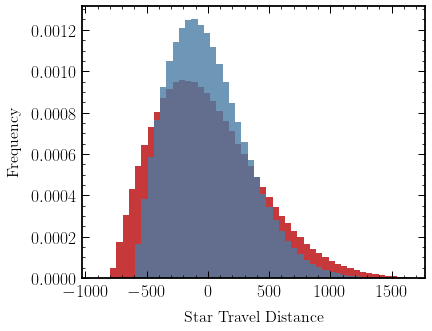

In [925]:
data = (x[:,:,-1,0] - x[:,:,0,0]).flatten()
data2 = (x2[:,:,-1,0] - x2[:,:,0,0]).flatten()
pt.get_hist(plt, data, 50, [-900,1650]) #[-300,450] #[-120,200]
pt.get_hist(plt, data2, 50, [-900,1650], alpha=0.8, 
         xlabel='Star Travel Distance') #title='Greg has fatter tails')

Text(0.5, 1.0, "Greg's Data")

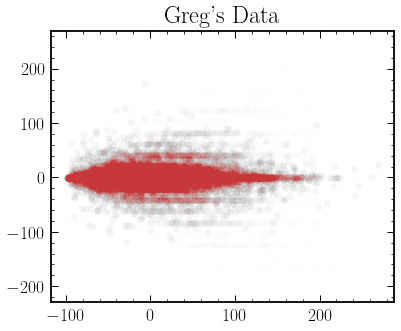

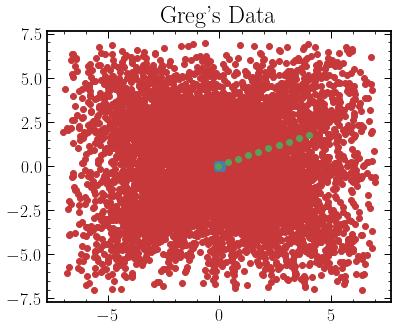

In [679]:
plt.figure()
# plt.axis([-120,250, -250, 250])
# plt.axis([-.12,.12,-.12,.12])
# plt.scatter(x[:,:,:,0].flatten(), x[:,:,:,1].flatten(), alpha=.002)
plt.scatter(x2[:,:,:,0].flatten(), x2[:,:,:,1].flatten(), alpha=2e-3)
plt.title('Greg\'s Data', fontsize=24)

plt.figure()
plt.scatter(lens_pos[:,:,0].flatten(), lens_pos[:,:,1].flatten(), alpha=1e-0)
plt.scatter(lens_pos[:,0,0].flatten(), lens_pos[:,0,1].flatten(), alpha=1e-0)

ind = 8
# print(nrm(lenses[ind*N_spl].x))
plt.scatter(lens_pos[ind,:,0].flatten(), lens_pos[ind,:,1].flatten(), alpha=1e-0)
plt.title('Greg\'s Data', fontsize=24)

Text(0.5, 1.0, "Sid's Data")

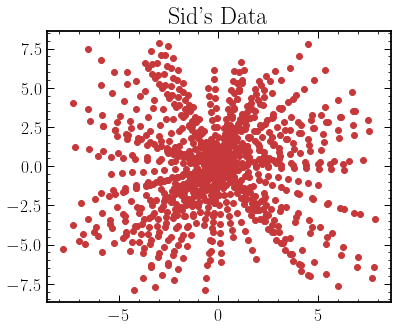

In [488]:
plt.figure()
# plt.axis([-120,250, -250, 250])
# plt.axis([-.12,.12,-.12,.12])
plt.scatter(y_pos[:,:,0].flatten(), y_pos[:,:,1].flatten(), alpha=1e-0)
plt.title('Sid\'s Data', fontsize=24)

# Time-series deep set model

In [394]:
import sys
sys.path.append("../")

In [395]:
from models.networks import build_mlp, build_maf
from models.sets import DeepSetLSTM, SetTransformerLSTM

In [396]:
dsl = DeepSetLSTM(output_dim=2)
dsl(x[:8]).shape

torch.Size([8, 2])

In [397]:
stl = SetTransformerLSTM(num_outputs=1, dim_output=2)
stl(x[:8]).shape

torch.Size([8, 2])

In [26]:
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

In [27]:
# Standardize input data by Z-scoring
x = (x - x.mean(0).mean(0)) / x.std(0).std(0)

# GR: Was infinity, now zero again
x[:, :, 0, :] = 0.

# Classification

In [28]:
val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

In [29]:
class MultiBlipClassifier(pl.LightningModule):

    def __init__(self):
        """ Lightning module
        """
        super().__init__()
#         self.deepset = DeepSetLSTM()
        self.deepset = SetTransformerLSTM(num_outputs=1, dim_output=1)

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.deepset(x)
        # GR: Binary cross-entropy loss function, essentially \sum_{two classes} x log y
        #    With logits means applying sigmoid before applying loss function
        #.   You know something wrong when the loss is log(2) = .693
        loss = nn.BCEWithLogitsLoss(reduction='mean')(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.deepset(x)[:, 0]
        loss = nn.BCEWithLogitsLoss(reduction='mean')(y_hat, y)
        self.log('val_loss', loss)

In [32]:
model = MultiBlipClassifier()
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=25, gpus=1, gradient_clip_val=1., callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: /Users/gregoryridgway/Desktop/AstroML/Astrometric_TSeries_ML/notebooks/lightning_logs

  | Name    | Type               | Params
-----------------------------------------------
0 | deepset | SetTransformerLSTM | 4.6 M 
-----------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.253    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate classification performance

In [184]:
model.to('cuda')
model.eval()

y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch = batch
    y_hat.append(torch.sigmoid(model.deepset(x_batch.to('cuda'))).to('cpu').detach().numpy())
    y_val.append(y_batch)

  0%|          | 0/16 [00:00<?, ?it/s]

In [185]:
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

In [186]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

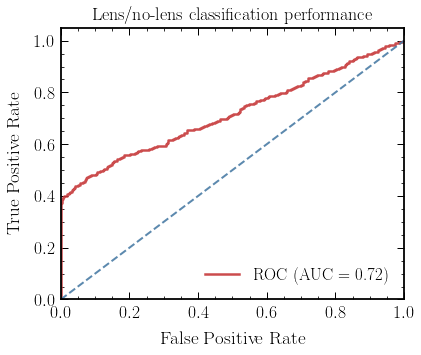

In [187]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

# Inference

In [400]:
y_lens_prop_mean = y_lens_prop.mean(-2)
y_lens_prop_std = y_lens_prop.std(-2)

y_lens_prop = (y_lens_prop - y_lens_prop_mean) / y_lens_prop_std

In [401]:
y_lens_prop = torch.Tensor(y_lens_prop)

In [402]:
val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y, y_lens_prop)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [403]:
from models.sets import DeepSetLSTM, SetTransformerLSTM

In [404]:
build_mlp(input_dim=64, hidden_dim=1024, output_dim=64, layers=0)

Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=64, bias=True)
)

In [405]:
class MultiBlipInference(pl.LightningModule):

    def __init__(self, output_dim=128):
        """ Lightning module
        """
        super().__init__()
#         self.deepset = DeepSetLSTM(hidden_dim=64, output_dim=128)
        self.deepset = SetTransformerLSTM(num_outputs=1, dim_output=128)
        self.flow = build_maf(dim=2, num_transforms=8, context_features=64, hidden_features=128)
        self.mlp_y_hat = build_mlp(input_dim=64, hidden_dim=512, output_dim=1, layers=0)
        self.mlp_post = build_mlp(input_dim=64, hidden_dim=512, output_dim=64, layers=0)

    def configure_optimizers(self):
        
        optimizer = optim.AdamW(self.parameters(), lr=3e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
        
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
    
    def training_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.deepset(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_class + loss_post

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, y_lens = batch
        
        out = self.deepset(x)
        
        out_post, out_y_hat = torch.chunk(out, 2, -1)
        out_post = self.mlp_post(out_post)
        y_hat = self.mlp_y_hat(out_y_hat)[:, 0]
        
        loss_class = nn.BCEWithLogitsLoss()(y_hat, y).mean()
        loss_post = -self.flow.log_prob(y_lens[y == 1.], context=out_post[y == 1.]).mean()

        loss = loss_class + loss_post

        self.log('val_loss', loss)
        return loss


In [406]:
model = MultiBlipInference()

In [407]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(max_epochs=25, gpus=1, gradient_clip_val=1., callbacks=[checkpoint_callback, early_stop_callback, lr_monitor])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model.load_from_checkpoint(checkpoint_callback.best_model_path);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type               | Params
-------------------------------------------------
0 | deepset   | SetTransformerLSTM | 3.4 M 
1 | flow      | Flow               | 342 K 
2 | mlp_y_hat | Sequential         | 33.8 K
3 | mlp_post  | Sequential         | 66.1 K
-------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.563    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate

In [408]:
model.to('cuda');
model.eval();

In [409]:
y_hat = []
y_val = []
for batch in tqdm(val_loader):
    x_batch, y_batch, y_lens_batch = batch
    out_batch = model.deepset(x_batch.to('cuda'))
    y_hat.append(torch.sigmoid(model.mlp_y_hat(torch.chunk(out_batch, 2, -1)[-1])).to('cpu').detach().numpy())
    y_val.append(y_batch)

  0%|          | 0/79 [00:00<?, ?it/s]

In [410]:
y_hat = np.concatenate(y_hat)
y_test = np.concatenate(y_val)

In [411]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

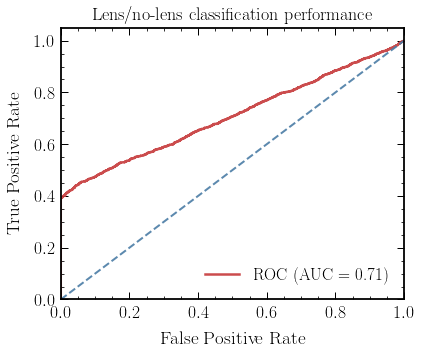

In [412]:
plt.plot(fpr, tpr, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Lens/no-lens classification performance")
plt.legend(loc="lower right")
plt.show()

In [413]:
def destandardize(samples):
    return samples * y_lens_prop_std + y_lens_prop_mean

In [414]:
# import seaborn as sns

# fig = plt.figure(figsize=(12, 12))

# gs = GridSpec(4, 4)

# for ii, i in tqdm(enumerate(range(16, 16 + 16))):
    
#     ax = fig.add_subplot(gs[ii])
    
#     idx = torch.where(y == 1)[0][i].numpy()
#     context = model.mlp_post(torch.chunk(model.deepset(x[idx].unsqueeze(0).to('cuda')), 2, -1)[0])
#     samples, log_prob = model.flow.sample_and_log_prob(num_samples=5000, context=context)

#     samps = np.nan_to_num(samples.cpu().detach().numpy()[0]).T
    
#     sns.kdeplot(x=samps[0], y=samps[1], fill=True, levels=50, cmap=sns.color_palette("Blues", as_cmap=True), thresh=0.5, alpha=0.65, ax=ax)
    
#     ax.axvline(y_lens_prop[idx].numpy()[0])
#     ax.axhline(y_lens_prop[idx].numpy()[1])
    

/n/home11/smsharma/.conda/envs/deepsets/lib/python3.9/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


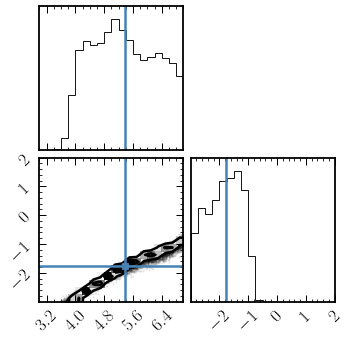

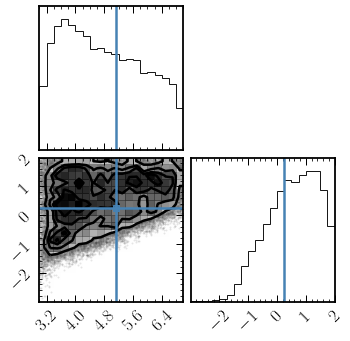

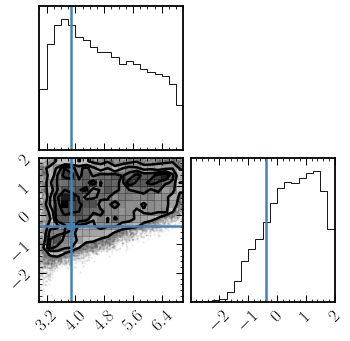

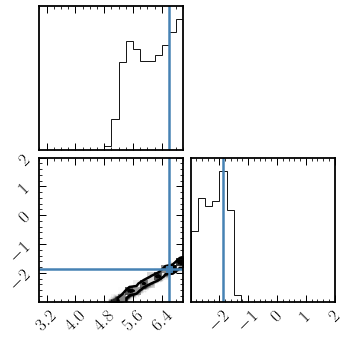

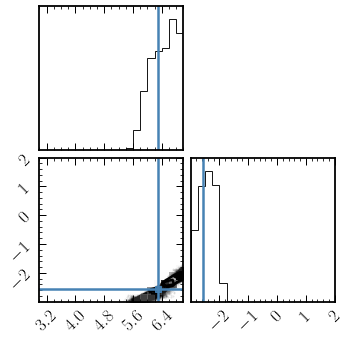

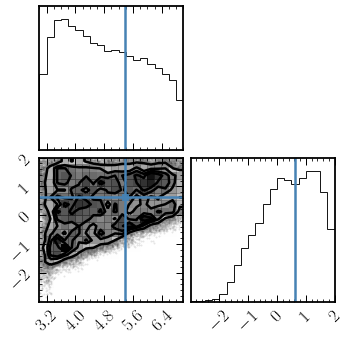

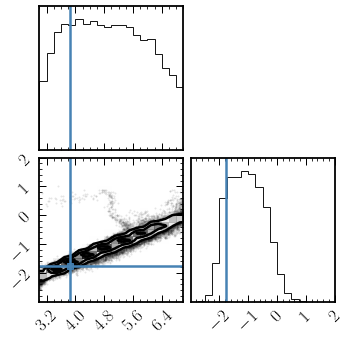

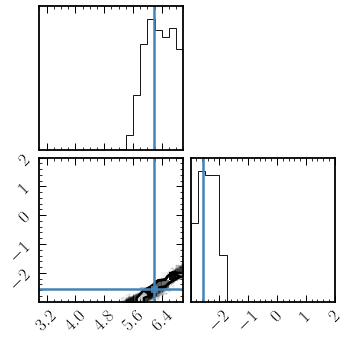

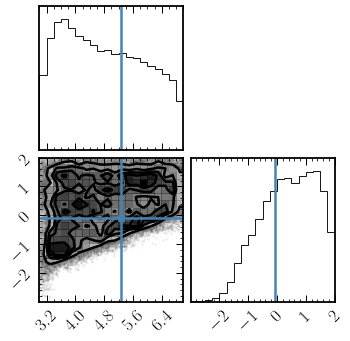

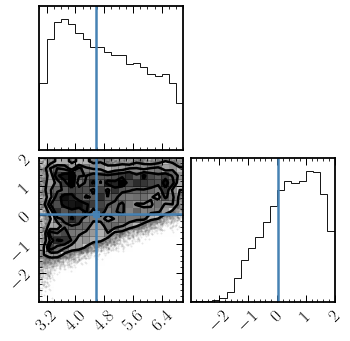

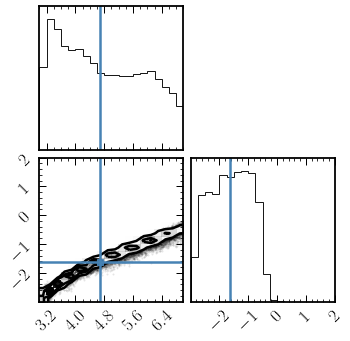

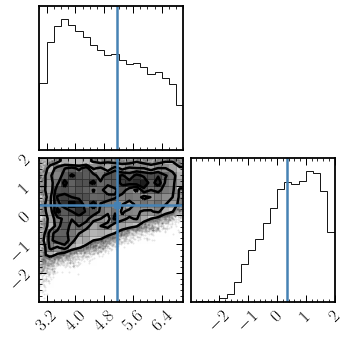

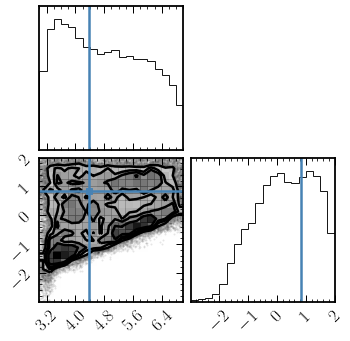

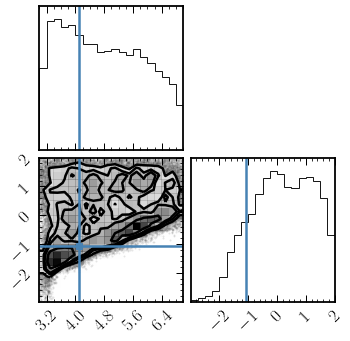

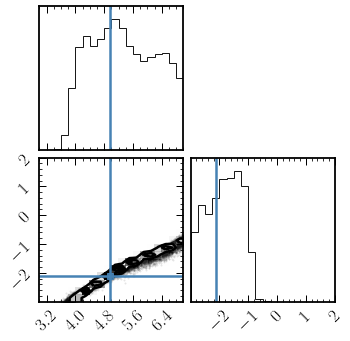

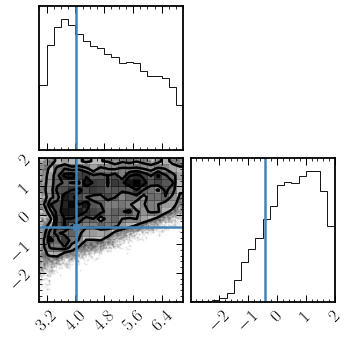

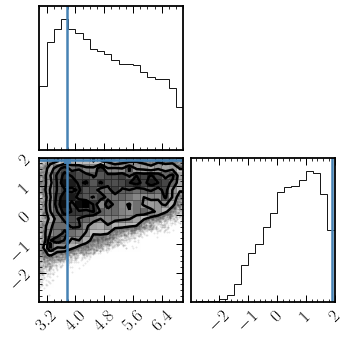

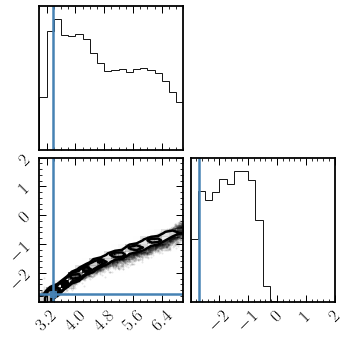

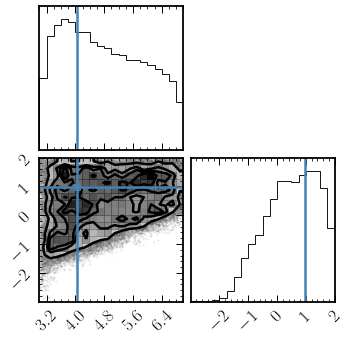

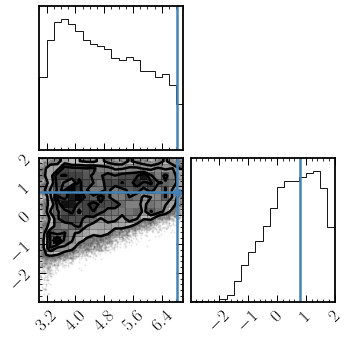

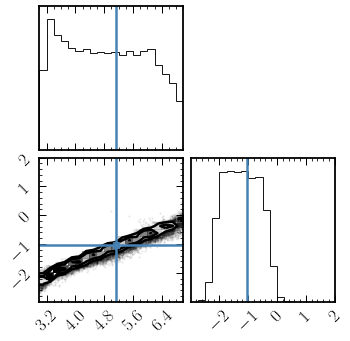

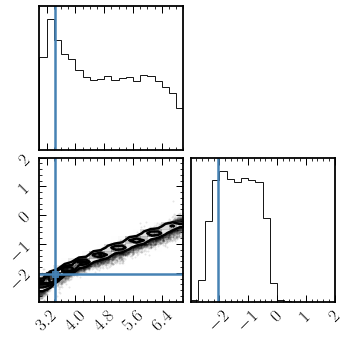

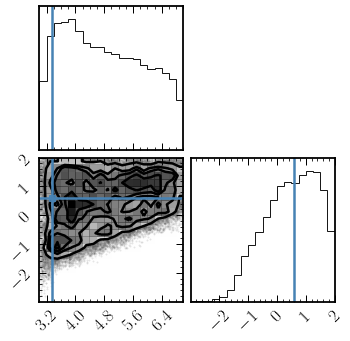

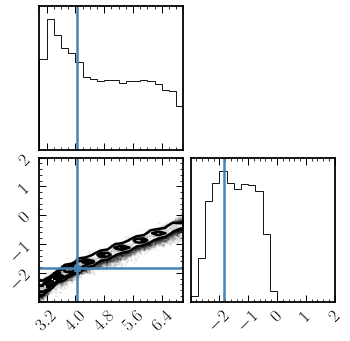

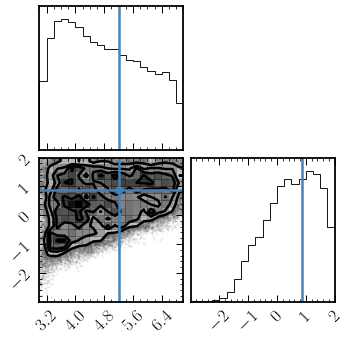

In [415]:
import corner

for i in range(10, 35):

    idx = torch.where(y == 1)[0][i].numpy()
    context = model.mlp_post(torch.chunk(model.deepset(x[idx].unsqueeze(0).to('cuda')), 2, -1)[0])
    samples, log_prob = model.flow.sample_and_log_prob(num_samples=50000, context=context)
    corner.corner(destandardize(samples.cpu().detach().numpy()[0]) , truths=destandardize(y_lens_prop[idx].numpy()), range=[[3,7],[-3,2]]);
    

# Scratch

In [151]:
from astropy.coordinates import SkyCoord
tab = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/'+
                       'Astrometric_TSeries_ML/data/Gaia_DR2_10kpc_mag10', 'rb'))

tab['pmra'].unit = 'mas / yr'
tab['pmdec'].unit = 'mas / yr'
tab['radial_velocity'].unit = 'km / s'

mag = np.array(tab['phot_g_mean_mag'])
scnow = SkyCoord(
    tab['ra'], 
    tab['dec'], 
    distance=(np.array(tab['parallax'])*u.mas).to(u.pc, u.parallax())
)

# Proper Motion

# scpm = SkyCoord(scnow, pm_dec=u.Quantity(tab['pmdec'][msk]),
#     pm_ra_cosdec=u.Quantity(tab['pmra'][msk])*np.cos(scnow.dec))
# scpmecl = scpm.barycentrictrueecliptic
scpmrv = SkyCoord(scnow, pm_dec=u.Quantity(tab['pmdec']),
                       pm_ra_cosdec=u.Quantity(tab['pmra'])*np.cos(scnow.dec),
                       radial_velocity=u.Quantity(tab['radial_velocity'].filled(0))
               )

In [535]:
scpmrv.velocity

<CartesianDifferential (d_x, d_y, d_z) in km / s
    [(-27.24409614, 21.77907731, -31.86804804),
     ( 13.1884435 ,  6.43634876,   2.27356602),
     ( 12.36849582, 36.27906119,  28.11561606), ...,
     (  8.86938407, 20.37422411, -14.10972638),
     ( -2.6818939 , 10.99433126,  16.01736404),
     (  9.43666305, 37.86354785, -12.99971284)]>

In [538]:
vel_norms*1e-9/(scpmrv.distance.value * 1e-3) * lt.rad_to_muas

array([191528.2045255 ,  11631.9676978 , 423346.51349137, ...,
        10093.65640247,   5503.48870582,  32786.58572199])

In [541]:
np.mean(scpmrv.distance.value)

619.2635054971885

In [544]:
8e-8 * lt.rad_to_muas * 1e-6

0.016501184499767705

In [540]:
np.mean(vel_norms)

40.500026407470614

In [539]:
np.mean(np.abs(tab['pmra']*1e-3))

0.01716928330451137

In [234]:
vels = np.transpose([
    scpmrv.velocity.d_x.value, 
    scpmrv.velocity.d_y.value, 
    scpmrv.velocity.d_z.value])

vel_norms = lt.multinorm(vels)
v_phi = np.arctan2(vels[:,1], vels[:,0])
v_theta = np.arccos(vels[:,1]/vel_norms)

$$
\begin{alignat}{1}
v_x &= v \sin \theta_v \cos \phi_v \\
v_y &= v \sin \theta_v \sin \phi_v \\
v_z &= v \cos \theta_v
\end{alignat}
$$

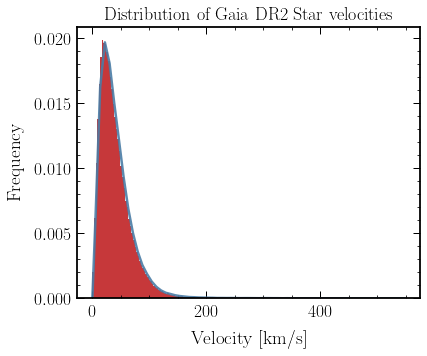

In [225]:
a,b = np.histogram(vel_norms[vel_norms < 550], bins=200, density=True)
x = (b[1:] + b[:-1])/2
b_width = np.diff(b)[0]
plt.bar(x, a, b_width)
plt.xlabel('Velocity [km/s]')
plt.ylabel('Frequency')
plt.title('Distribution of Gaia DR2 Star velocities')


window = 3
data = [[0,0]]
for i in np.arange(0,len(a),window):
    data.append([b[i+2], np.sum(a[i:i+window])/window])

data = np.array(data)

plt.plot(data[:,0], data[:,1], color='C1')

# inv_cdf = interp1d(np.cumsum(data[:,1])*b_width*3, data[:,0], fill_value='extrapolate')

# pickle.dump(inv_cdf, open('/Users/gregoryridgway/Desktop/AstroML/data/Gaia_DR2_inv_cdf', 'wb'))

# plt.axvline(150, linestyle='--', color='k')

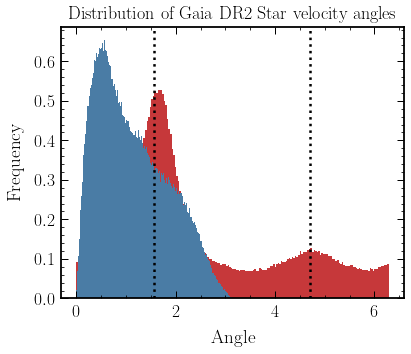

In [243]:
a,b = np.histogram(v_phi % (2 * np.pi), bins=200, density=True)
x = (b[1:] + b[:-1])/2
b_width = np.diff(b)[0]
plt.bar(x, a, b_width)
plt.xlabel('Velocity [km/s]')
plt.ylabel('Frequency')
plt.title('Distribution of Gaia DR2 Star velocities')

a,b = np.histogram(v_theta, bins=200, density=True)
x = (b[1:] + b[:-1])/2
b_width = np.diff(b)[0]
plt.bar(x, a, b_width)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.title('Distribution of Gaia DR2 Star velocity angles')

plt.axvline(np.pi/2, color='k', linestyle=':')
plt.axvline(3*np.pi/2, color='k', linestyle=':')


# window = 3
# data = [[0,0]]
# for i in np.arange(0,len(a),window):
#     data.append([b[i+2], np.sum(a[i:i+window])/window])

# data = np.array(data)

# plt.plot(data[:,0], data[:,1], color='C1')

In [214]:
lt.multinorm(vels)

array([47.24554443, 14.85027709, 47.53564805, ..., 26.3222218 ,
       19.61182872, 41.13017627])

In [188]:
np.mean(
    np.abs(np.array(tab['pmdec'])/(
        lt.rad_to_muas * 1e-3) * scnow.distance.value * 1e-3))

np.mean(
    np.abs(np.array(tab['pmra'])/(
        lt.rad_to_muas * 1e-3) * scnow.distance.value * 1e-3))

np.mean(np.abs(tab['radial_velocity'])) * 1e-9

2.366841588920736e-08

In [245]:
np.mean(vel_norms) * 1e-9

4.050002640747062e-08

In [246]:
lt.v_esc / 10

5.624916907751323e-08

# Lessons Learned

- Uniform distribution of lens => plenty at a distance of .01 => amplification of angular velocity => much different set of events.